In [57]:
import pandas as pd
import os
import numpy as np

In [58]:
file_dir = r'C:\Users\xry\Documents\bond_data.csv'
data = pd.read_csv(file_dir)

In [59]:
data_new = data.iloc[[0,6,8,10,12,26,27,28,29,31]]
index = [i for i in range(data_new.shape[0])]
data_new.index = index

In [60]:
clean_price = data_new.iloc[:,5:]
maturity_date = pd.to_datetime(data_new.loc[:,'Maturity Date'])

In [61]:
#calculate n
from datetime import datetime
from datetime import timedelta
n = clean_price.copy()
for j in range(10):
    if j >4 :
        current_date = datetime(2021,1,20+j)
    else:
        current_date = datetime(2021,1,18+j)
    for i in range(maturity_date.shape[0]):
        a = maturity_date[i]
        while (a-current_date).days > 0:
            a -= pd.DateOffset(months=6)
        n.iloc[i,j] = (current_date-a).days

In [62]:
#calculate accrued_interest & dirty_price
coupon = data_new.loc[:,'Coupon']
coupon = coupon.str.strip('%').astype(float)/100
accrued_interest = pd.DataFrame(np.array(n)*(np.array(coupon).reshape(-1,1))/365)
clean_price = pd.DataFrame(np.array(clean_price))
dirty_price = clean_price + accrued_interest

In [63]:
import sympy
import math
from scipy.optimize import fsolve

In [64]:
#the function to solve r
def f(r):
    if j >4 :
        current_date = datetime(2021,1,20+j)
    else:
        current_date = datetime(2021,1,18+j)
    if (maturity_date[i]-current_date).days<180:
        payment_date = maturity_date[i]
        payment = 100*coupon[i]/2*((payment_date-current_date).days)/182.5 + 100
        f = payment * math.exp(-r*(maturity_date[i]-current_date).days/365)-dirty_price.iloc[i,:][0]
    else:
        first_payment_date = maturity_date[i]
        while (first_payment_date-current_date).days > 180:
            first_payment_date -= pd.DateOffset(months=6)
        payment_date = first_payment_date
        payment = 100*coupon[i]/2*((payment_date-current_date).days)/182.5
        f = payment * math.exp(-r*(payment_date-current_date).days/365)
        while((maturity_date[i]-payment_date).days > 180):
            payment_date += pd.DateOffset(months=6)
            payment = 100*coupon[i]/2
            f += payment * math.exp(-r*(payment_date-current_date).days/365)     
        f += 100* math.exp(-r*(payment_date-current_date).days/365)
        f -= dirty_price.iloc[i,:][0]
    return f

In [65]:
#solve r
yield_to_maturity = clean_price.copy()
for i in range(10):
    for j in range(10):
        result=fsolve(f,0.004)
        yield_to_maturity.iloc[i,j] = result[0]

In [66]:
yield_to_maturity['Name']=data_new.loc[:,'Name']
date_to_maturity = yield_to_maturity.copy()
for j in range(10):
    if j >4 :
        current_date = datetime(2021,1,20+j)
    else:
        current_date = datetime(2021,1,18+j)
    for i in range (maturity_date.shape[0]):
        date_to_maturity.iloc[i,j] = (maturity_date[i]-current_date).days/365

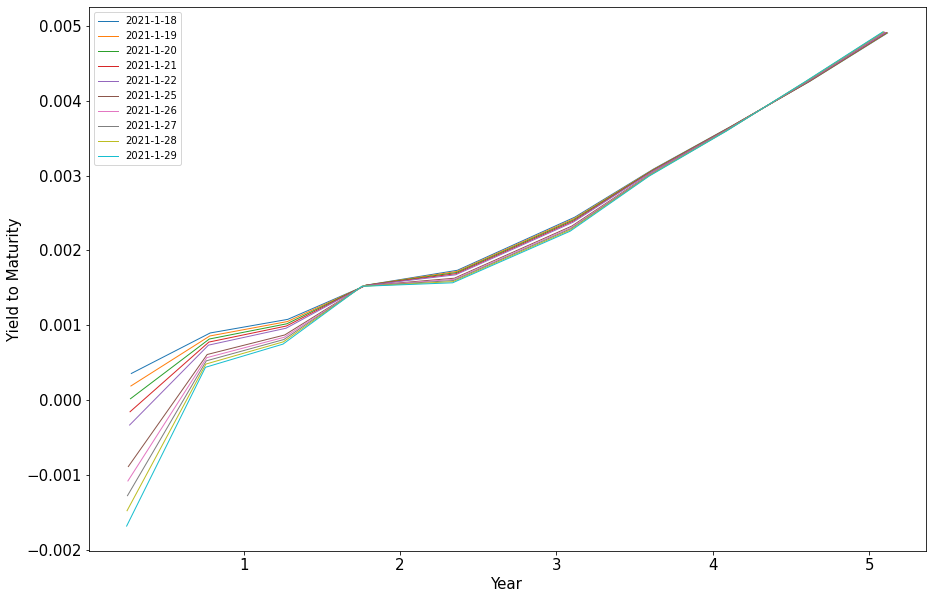

In [67]:
#plt the yield to maturity curve
from scipy import interpolate
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.xlabel('Year',fontsize=15)
plt.ylabel('Yield to Maturity',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

for j in range(10):
    x = date_to_maturity[j]
    y = yield_to_maturity[j]
    points = zip(x,y)
    sorted_points = sorted(points)
    x_new = [point[0] for point in sorted_points]
    y_new = [point[1] for point in sorted_points]
    if j>4:
        plt.plot(x_new,y_new,linewidth=1,label="2021-1-%d"%(20+j))
    else:
        plt.plot(x_new,y_new,linewidth=1,label="2021-1-%d"%(18+j))
plt.legend()
plt.show()

In [68]:
data_spot = dirty_price.copy()
data_spot['Maturity Date'] = maturity_date
data_spot['Coupon'] = coupon
data_spot = data_spot.sort_values(by='Maturity Date',axis=0)
index = [i for i in range(data_new.shape[0])]
data_spot.index = index

In [69]:
#calculate spot rate
spot_rate = data_spot.copy()
for j in range(10):
    if j >4 :
        current_date = datetime(2021,1,20+j)
    else:
        current_date = datetime(2021,1,18+j)
    sum = 0
    for i in range(data_spot.shape[0]):
        ti = (data_spot.loc[i,'Maturity Date']-current_date).days/365  
        coupon = data_spot.loc[i,'Coupon']/2
        p = data_spot.iloc[i,j]-sum*coupon*100
        spot_rate.iloc[i,j] = -1*math.log(p/(coupon*100*ti+100))/ti
        sum += ti*math.exp(-spot_rate.iloc[i,j]*ti)
        

In [70]:
date_to_maturity =  spot_rate.iloc[:,:-2].copy()
for j in range(10):
    if j >4 :
        current_date = datetime(2021,1,20+j)
    else:
        current_date = datetime(2021,1,18+j)
    for i in range (maturity_date.shape[0]):
        date_to_maturity.iloc[i,j] = (spot_rate.loc[i,'Maturity Date']-current_date).days/365


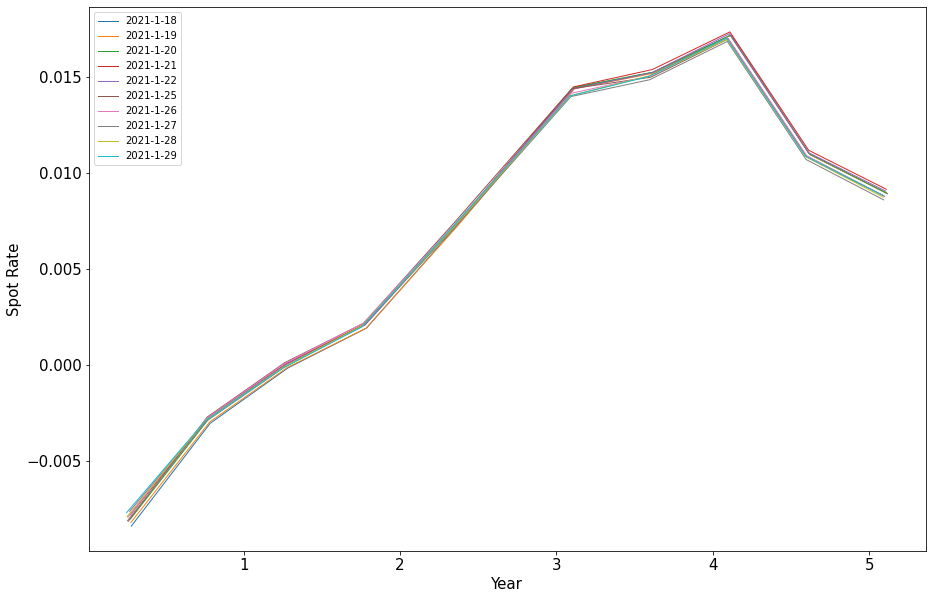

In [71]:
#plt spot rate curve
date_to_maturity_spot = date_to_maturity.sort_values(by = 0,axis=0)
plt.figure(figsize=(15,10))
plt.xlabel('Year',fontsize=15)
plt.ylabel('Spot Rate',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

for j in range(10):
    x = date_to_maturity_spot[j]
    y = spot_rate[j]
    if j>4:
        plt.plot(x,y,linewidth=1,label="2021-1-%d"%(20+j))
    else:
        plt.plot(x,y,linewidth=1,label="2021-1-%d"%(18+j))
plt.legend()
plt.show()

In [72]:
#calculate forward rate
forward_rate = [[] for i in range(10)]
for j in range(10):
    f = interpolate.interp1d(date_to_maturity_spot[j], spot_rate[j], kind='linear')
    x_new = 1
    spot_rate_1st = f(x_new)
    for i in range(2,10):
        a = (spot_rate.iloc[i,j]*date_to_maturity_spot.iloc[i,j]-spot_rate_1st*1)/(date_to_maturity_spot.iloc[i,j]-1)
        forward_rate[j].append(a)
        

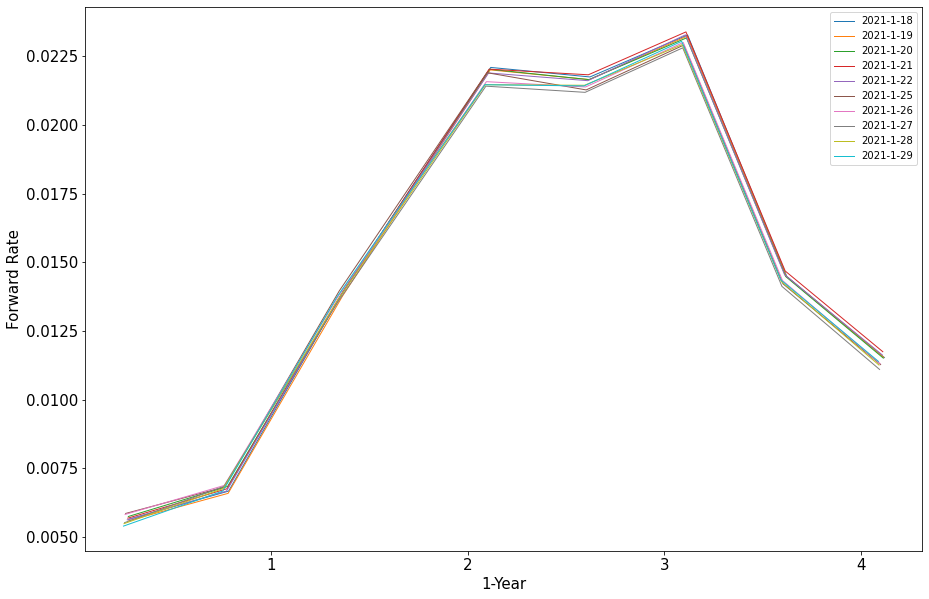

In [73]:
#plt forward rate curve
from matplotlib.pyplot import MultipleLocator
plt.figure(figsize=(15,10))
plt.xlabel('1-Year',fontsize=15)
plt.ylabel('Forward Rate',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax=plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1))

for j in range(10):
    x = date_to_maturity_spot[j][2:]-1
    y = forward_rate[j]
    if j>4:
        plt.plot(x,y,linewidth=1,label="2021-1-%d"%(20+j))
    else:
        plt.plot(x,y,linewidth=1,label="2021-1-%d"%(18+j))
   # plt.scatter(x,y)
plt.legend()
plt.show()

In [74]:
#interpolate forward rate
forward_rate_new = [[] for i in range(10)]
for j in range(10):
    x = date_to_maturity_spot[j][2:]-1
    y = forward_rate[j]
    f = interpolate.interp1d(x, y, kind='linear')
    x_new=[1,2,3,4]
    y_new=list(f(x_new))
    forward_rate_new[j].append(y_new)

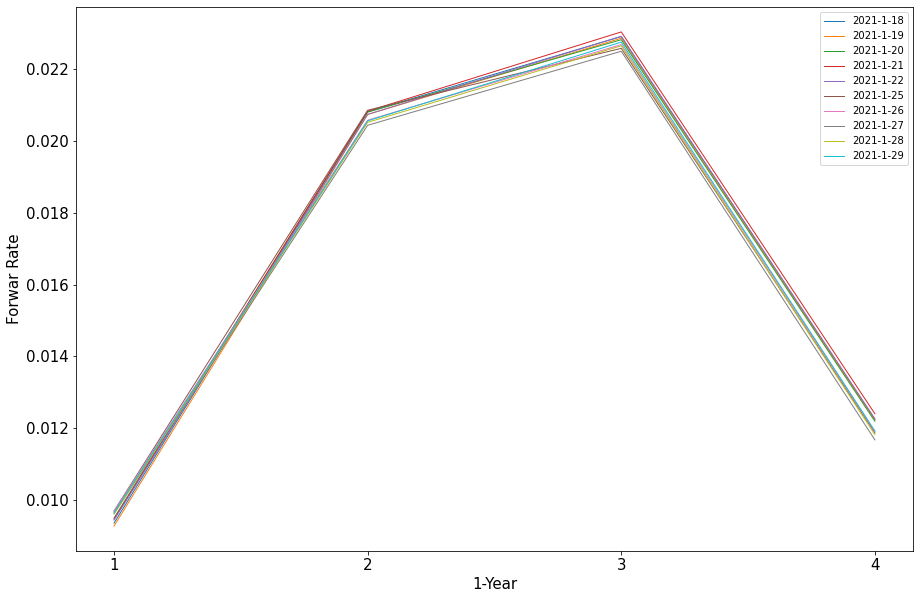

In [75]:
from matplotlib.pyplot import MultipleLocator
plt.figure(figsize=(15,10))
plt.xlabel('1-Year',fontsize=15)
plt.ylabel('Forwar Rate',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax=plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1))

for j in range(10):
    x = [1,2,3,4]
    y = forward_rate_new[j][0]
    if j>4:
        plt.plot(x,y,linewidth=1,label="2021-1-%d"%(20+j))
    else:
        plt.plot(x,y,linewidth=1,label="2021-1-%d"%(18+j))
   # plt.scatter(x,y)
plt.legend()
plt.show()

In [76]:
yield_to_maturity['Maturity Date'] = maturity_date
yield_to_maturity = yield_to_maturity.sort_values(by='Maturity Date',axis=0)
index = [i for i in range(data_new.shape[0])]
yield_to_maturity.index = index
yield_to_maturity_new = [[] for i in range(10)]
for j in range(10):
    x = date_to_maturity[j]
    y = yield_to_maturity[j]
    f = interpolate.interp1d(x, y, kind='linear')
    x_new=[1,2,3,4,5]
    y_new=list(f(x_new))
    yield_to_maturity_new[j].append(y_new)

In [77]:
# calculate covariance matrice for yield to maturity,eigenvalues and eigenvector
cov_mat = np.zeros([9,5])
for i in range(0,5):
    for j in range(1,10):
        x_ij = np.log((yield_to_maturity_new[j][0][i])/(yield_to_maturity_new[j-1][0][i]))
        cov_mat[j-1,i]=x_ij
yield_to_maturity_cov = np.cov(cov_mat.T)
eig_val, eig_vec = np.linalg.eig(yield_to_maturity_cov)
print(eig_val)
print(eig_vec)
pd.DataFrame(yield_to_maturity_cov)

[9.51034019e-04 9.64025027e-07 7.44052828e-10 2.06966378e-18
 1.55321291e-15]
[[-9.86798890e-01 -1.57186943e-01  3.89879074e-02  1.72751860e-04
   3.57815028e-04]
 [-8.68638675e-02  3.16752983e-01 -9.20853544e-01 -2.08113158e-01
   2.89807058e-02]
 [-1.33946301e-01  9.04259473e-01  2.55482521e-01  2.82381782e-01
  -1.39148874e-01]
 [-1.84984758e-02  1.80921388e-01  2.67109100e-01 -9.25995055e-01
  -1.95220697e-01]
 [ 1.99703098e-02 -1.56659083e-01 -1.17856286e-01  1.39579983e-01
  -9.70405308e-01]]


,0,1,2,3,4
0,0.000926,0.000081,0.000126,1.733303e-05,-1.871799e-05
1,0.000081,0.000007,0.000011,1.583231e-06,-1.697513e-06
2,0.000126,0.000011,0.000018,2.514240e-06,-2.680554e-06
3,0.000017,0.000002,0.000003,3.570458e-07,-3.786780e-07
4,-0.000019,-0.000002,-0.000003,-3.786780e-07,4.029545e-07


In [78]:
# calculate covariance matrice for forward maturity,eigenvalues and eigenvector
cov_mat = np.ones([9,4])
for i in range(0,4):
    for j in range(1,10):
        x_ij = np.log((forward_rate_new[j][0][i])/(forward_rate_new[j-1][0][i]))
        cov_mat[j-1,i]=x_ij
forward_rate_cov = np.cov(cov_mat.T)
eig_val, eig_vec = np.linalg.eig(yield_to_maturity_cov)
print(eig_val)
print(eig_vec)
pd.DataFrame(forward_rate_cov)

[9.51034019e-04 9.64025027e-07 7.44052828e-10 2.06966378e-18
 1.55321291e-15]
[[-9.86798890e-01 -1.57186943e-01  3.89879074e-02  1.72751860e-04
   3.57815028e-04]
 [-8.68638675e-02  3.16752983e-01 -9.20853544e-01 -2.08113158e-01
   2.89807058e-02]
 [-1.33946301e-01  9.04259473e-01  2.55482521e-01  2.82381782e-01
  -1.39148874e-01]
 [-1.84984758e-02  1.80921388e-01  2.67109100e-01 -9.25995055e-01
  -1.95220697e-01]
 [ 1.99703098e-02 -1.56659083e-01 -1.17856286e-01  1.39579983e-01
  -9.70405308e-01]]


,0,1,2,3
0,0.000166,4.686034e-05,-0.000040,-8.336662e-05
1,0.000047,3.835547e-05,-0.000003,9.943374e-07
2,-0.000040,-2.883523e-06,0.000062,1.235149e-04
3,-0.000083,9.943374e-07,0.000124,2.544843e-04
